# Multivariate Normal Model
In this section, we will study Bayesian inference for the multivariate normal distribution. This is a simple problem which forms an important building block for inference in more complex hierarchical models.
## Model
$$p(Y | \mu, \Sigma)=\operatorname{det}(2 \pi \Sigma)^{-n / 2} \exp \left[-\frac{1}{2} \sum_{i=1}^{n}\left(y_{i}-\mu\right)^{\prime} \Sigma^{-1}\left(y_{i}-\mu\right)\right]$$  
## Priors
$p(\mu)=N(\eta,C)$ and $p(\sigma^{-1})=W(\rho,\Omega)$

In [4]:
import numpy as np
import pandas as pd
import scipy.stats
from time import time

# The function below generates the multivariate normal draw for mu.
def ablMvnCoeff(yMean, invM, invC, eta, nobs):
    postPrec = invC + nobs*invM
    temp = np.matmul(invC, eta) + np.matmul(nobs*invM, yMean)
    postMean = np.linalg.solve(postPrec, temp)
    # return ablRanNormalPrec(postPrec, postMean)
    return np.random.multivariate_normal(postMean, np.linalg.inv(postPrec))

# The function below generates the Wishart draw for the precision matrix invM 
def ablMvnErrorPrec(yMatrix, mu, invOmega, rho, nobs):
    lmat = np.array([yMatrix[i] - mu for i in range(nobs)]);
    ip = np.matmul(lmat.T,lmat) + invOmega;
    # return ablRanWishartInvScale(ip, rho + nobs)
    return scipy.stats.wishart.rvs(df = rho + nobs, scale = np.linalg.inv(ip))

In [5]:
# Data
npar = 5; nobs = 1000;
mu = np.array([-3.0,1.5, 0.8, 2.0, 1.0])
M = 0.5*np.identity(npar) + 0.5*np.ones([npar,npar])
invM = np.linalg.inv(M)
y = np.array([np.random.multivariate_normal(mu, M) for i in range(nobs)])
yMean = np.mean(y,0)
yVar = np.cov(y.T)

In [6]:
print(yMean)
print(yVar)

[-2.97967341  1.46789293  0.81311982  1.97483216  0.98558138]
[[0.93919539 0.48514283 0.48866694 0.48293511 0.47719683]
 [0.48514283 1.00454714 0.4929159  0.48096756 0.51115239]
 [0.48866694 0.4929159  0.9298457  0.4697818  0.45049579]
 [0.48293511 0.48096756 0.4697818  1.01130758 0.45947435]
 [0.47719683 0.51115239 0.45049579 0.45947435 0.98565808]]


In [7]:
#Setting Priors
#Wishart Prior
rho = 7
invOmega = (rho - npar - 1) * np.identity(npar)
Omega = np.linalg.inv(invOmega)
#Normal Prior
eta = np.zeros(npar)
invC = 0.001*np.identity(npar)
#Starting Values
mu = np.zeros(npar)
invM = 0.5*np.identity(npar)
niter = 5000
#MCMC Draws
muDraws = []
sigmaDraws = []
t0 = time()
for i in range(niter):
    mu = ablMvnCoeff(yMean, invM, invC, eta, nobs)
    invM = ablMvnErrorPrec(y, mu, invOmega, rho, nobs)
    muDraws.append(mu)
    sigmaDraws.append(np.linalg.inv(invM))
print("Done in %0.3fs." % (time() - t0))

Done in 10.502s.


In [8]:
#Output and Results
print(sum(muDraws)/niter)
print(yMean)

[-2.97967546  1.46776929  0.81315362  1.97567051  0.98630246]
[-2.97967341  1.46789293  0.81311982  1.97483216  0.98558138]


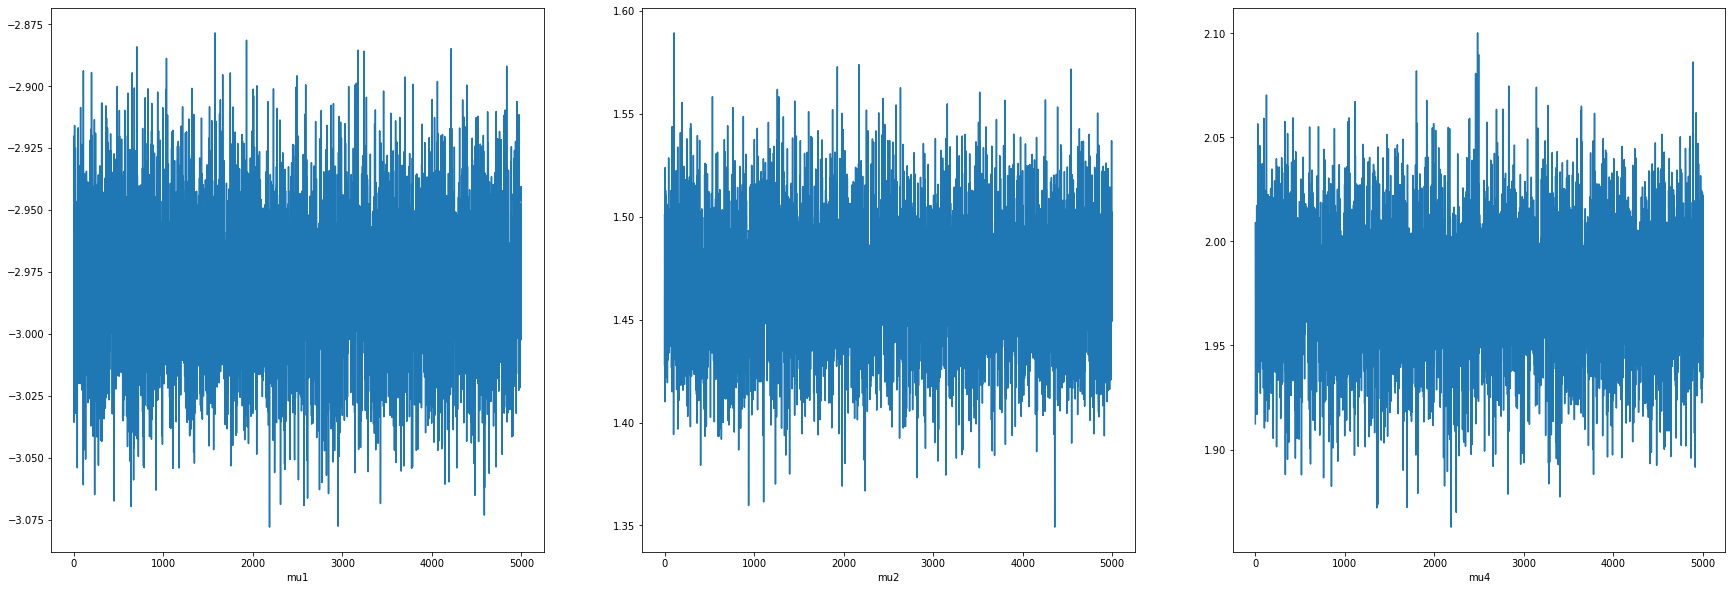

In [9]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(30, 10)) 
plt.subplot(1,3,1)
plt.plot(range(niter),np.array(muDraws)[:,0])
plt.xlabel('mu1')
plt.subplot(1,3,2)
plt.plot(range(niter),np.array(muDraws)[:,1])
plt.xlabel('mu2')
plt.subplot(1,3,3)
plt.plot(range(niter),np.array(muDraws)[:,3])
plt.xlabel('mu4')
plt.show()

In [10]:
df = pd.DataFrame(np.array(muDraws))
df.columns = ['mu1','mu2','mu3','mu4','mu5']
df.describe()

,mu1,mu2,mu3,mu4,mu5
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-2.979675,1.467769,0.813154,1.975671,0.986302
std,0.030248,0.031319,0.030050,0.031374,0.030814
min,-3.078057,1.349209,0.707579,1.862811,0.876888
25%,-3.000305,1.446287,0.792821,1.954471,0.965645
50%,-2.979195,1.467477,0.813221,1.975746,0.985975
75%,-2.959421,1.488977,0.833816,1.996759,1.007916
max,-2.878521,1.589252,0.915819,2.100085,1.092990


In [11]:
df = pd.DataFrame(np.array(sigmaDraws).reshape([-1,npar*npar]))
name = []
for i in range(npar):
    for j in range(npar):
        name.append('sigma'+str(i)+str(j))
df.columns = name
df.describe()

,sigma00,sigma01,sigma02,sigma03,sigma04,sigma10,sigma11,sigma12,sigma13,sigma14,...,sigma30,sigma31,sigma32,sigma33,sigma34,sigma40,sigma41,sigma42,sigma43,sigma44
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.940075,0.484671,0.488425,0.482717,0.476942,0.484671,1.004345,0.492681,0.480715,0.510630,...,0.482717,0.480715,0.469342,1.011385,0.459352,0.476942,0.510630,0.450112,0.459352,0.986319
std,0.042396,0.034614,0.033403,0.033820,0.034095,0.034614,0.045626,0.034572,0.034872,0.035169,...,0.033820,0.034872,0.033882,0.044362,0.034472,0.034095,0.035169,0.033631,0.034472,0.044100
min,0.791487,0.377018,0.367646,0.356508,0.369221,0.377018,0.865001,0.361823,0.353441,0.382242,...,0.356508,0.353441,0.368186,0.876455,0.335186,0.369221,0.382242,0.326847,0.335186,0.856896
25%,0.910794,0.461125,0.465702,0.459811,0.453032,0.461125,0.972532,0.468553,0.457043,0.486070,...,0.459811,0.457043,0.446119,0.980550,0.436045,0.453032,0.486070,0.427444,0.436045,0.955881
50%,0.938795,0.483140,0.487692,0.482216,0.476348,0.483140,1.001763,0.491956,0.479468,0.509521,...,0.482216,0.479468,0.468410,1.009686,0.458614,0.476348,0.509521,0.448512,0.458614,0.985006
75%,0.968008,0.507246,0.510254,0.505102,0.499179,0.507246,1.035262,0.516004,0.503740,0.533497,...,0.505102,0.503740,0.491766,1.040594,0.481525,0.499179,0.533497,0.471914,0.481525,1.014973
max,1.100327,0.621773,0.619681,0.622017,0.615592,0.621773,1.179747,0.625302,0.632101,0.658725,...,0.622017,0.632101,0.606954,1.177575,0.584583,0.615592,0.658725,0.573209,0.584583,1.151008
